In [45]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import scipy.optimize
import random
from collections import defaultdict
from collections import Counter
import nltk
import string
from nltk.stem.porter import *
from sklearn import linear_model
import random
from statistics import mode
from collections import Counter
from operator import itemgetter
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import nltk

In [3]:
df = pd.read_csv("Hotel_Reviews.csv")

In [4]:
# Get country of hotel for all reviews
countries = []

for index, row in df.iterrows():
    address = row['Hotel_Address'].split()
    country = address[-1]
    
    # Encode country with following code: 0 - Netherlands, 1 - UK, 2 - France, 3 - Spain, 4 - Italy, 5 - Austria
    # Handle if country is UK
    if country == 'Netherlands':
        countries.append(0)
    elif country == 'Kingdom':
        countries.append(1)
    elif country == 'France':
        countries.append(2)
    elif country == 'Spain':
        countries.append(3)
    elif country == 'Italy':
        countries.append(4)
    elif country == 'Austria':
        countries.append(5)

# Append country of hotel into dataframe to use as a distinct feature
df['Country'] = pd.Series(countries).values

In [5]:
# Build a dataset that contains unique hotels only
dfStripped = df[['Hotel_Address', 'Average_Score', 'Hotel_Name', 'Total_Number_of_Reviews', 'Country']].copy()
dfStripped = dfStripped.drop_duplicates()

# Sort by average score in descending order and print top 10 
dfStripped.sort_values(by=['Average_Score'], ascending=False).head(10)

,Hotel_Address,Average_Score,Hotel_Name,Total_Number_of_Reviews,Country
54717,15 Place Vend me 1st arr 75001 Paris France,9.8,Ritz Paris,122,2
402244,Pau Claris 179 Eixample 08037 Barcelona Spain,9.6,H10 Casa Mimosa 4 Sup,454,3
185602,41 Buckingham Palace Road Westminster Borough ...,9.6,41,244,1
398945,Passeig de Colom 9 Ciutat Vella 08002 Barcelon...,9.6,Hotel The Serras,604,3
176997,4 rue d Alger 1st arr 75001 Paris France,9.6,H tel de La Tamise Esprit de France,166,2
316447,Elisabets 11 Ciutat Vella 08001 Barcelona Spain,9.6,Hotel Casa Camper,732,3
14708,1 Suffolk Place Westminster Borough London SW1...,9.6,Haymarket Hotel,255,1
390999,One Ham Yard Westminster Borough London W1D 7D...,9.5,Ham Yard Hotel,314,1
312809,Dels Lledo 7 Ciutat Vella 08003 Barcelona Spain,9.5,Mercer Hotel Barcelona,362,3
81101,19 Boulevard De La Tour Maubourg 7th arr 75007...,9.5,Le Narcisse Blanc Spa,222,2


In [6]:
# Find which country has the most distinct hotels
# Find average rating by country

countryHotelDict = dict() # Used to count distinct hotels
countryScoreDict = dict() # Used to count distinct scores

for index, row in dfStripped.iterrows():
    score = row['Average_Score']
    hotel = row['Hotel_Name']
    country = row['Country']
    if country not in countryHotelDict:
        countryHotelDict[country] = [hotel]
        countryScoreDict[country] = [score]
    elif hotel not in countryHotelDict[country]:
        countryHotelDict[country].append(hotel)
        countryScoreDict[country].append(score)
        
countryHotelCount = dict() # Associate entire country with num of hotels
countryScoreCount = dict() # Associate entire country with average score

for key, value in countryScoreDict.items():
    countryScoreCount[key] = sum(value)/len(value)

for key, value in countryHotelDict.items():
    countryHotelCount[key] = len(value)

In [7]:
print(countryHotelCount)
print(countryScoreCount)

{0: 105, 1: 400, 2: 458, 3: 211, 4: 162, 5: 158}
{0: 8.409523809523808, 1: 8.464000000000004, 2: 8.493668122270746, 3: 8.496208530805688, 4: 8.318518518518518, 5: 8.549999999999995}


Even though Austria has one of the fewest number of distinct hotels, it has the highest average rating of all hotels. Interesting because Austria does not show up in the top 10 hotels. 

### Relationship between number of reviews a reviewer gives and their average rating

In [8]:
# Find average rating based on number of reviews by user
numReviewsRatingDict = dict()

for index, row in df.iterrows():
    numReviews = row['Total_Number_of_Reviews_Reviewer_Has_Given']
    rating = row['Reviewer_Score']
    if numReviews not in numReviewsRatingDict:
        numReviewsRatingDict[numReviews] = [rating]
    else:
        numReviewsRatingDict[numReviews].append(rating)

In [9]:
# Associate number of reviews with the average rating for that number

numReviewsAvgRatingDict = dict()

for key,value in numReviewsRatingDict.items():
    numReviewsAvgRatingDict[key] = sum(value)/len(value)

Text(0,0.5,'Average Rating')

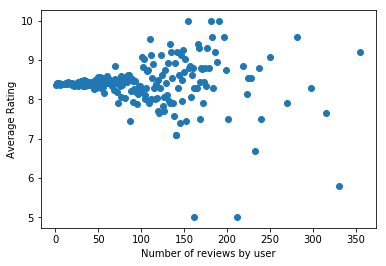

In [10]:
# Generate scatter plot to visualize the data 
X = []
y = []

for key, value in numReviewsAvgRatingDict.items():
    X.append(key)
    y.append(value)
    
plt.scatter(X, y)
plt.xlabel('Number of reviews by user')
plt.ylabel('Average Rating')

The fewer reviews a user gives, the closer the average is to 8.5

### Relationship between month of year and rating

In [11]:
#map of all months and a list of all their ratings
months_ratings = defaultdict(list)

for date, rating in zip(df['Review_Date'], df['Reviewer_Score']):
    month = date.split("/")[0]
    months_ratings[month].append(rating)
    
for month in range(1,13):
    print(month, sum(months_ratings[str(month)])/len(months_ratings[str(month)]))

1 8.48501103177
2 8.52805837894
3 8.47983215763
4 8.43152997691
5 8.3810410841
6 8.3914187803
7 8.33548602944
8 8.41173823808
9 8.29064768549
10 8.26157653445
11 8.33884348068
12 8.42713156765


In [12]:
# Append month of review to dataframe
months = []

for date in df['Review_Date']:
    month = date.split("/")[0]
    months.append(month)

df['Month'] = pd.Series(months).values

The month with the highest rating is February. As a general trend it seems that the winter months tend to have higher rating on average than the spring and summer months. Possibly people are more thankful to have shelter when its cold? Or perhaps people are more critical during the summer

### Relationship between trip type and rating

In [13]:
trip_type_ratings = defaultdict(list)

for tags, rating in zip(df['Tags'], df['Reviewer_Score']):
    L = ' Leisure trip '
    B = ' Business trip '
    if L in tags:
        trip_type_ratings[L].append(rating)
    elif B in tags:
        trip_type_ratings[B].append(rating)
    else:
        continue
        
leisure_ratings = trip_type_ratings[' Leisure trip ']
business_ratings = trip_type_ratings[' Business trip ']

leisure_avg = sum(leisure_ratings)/len(leisure_ratings)
business_avg = sum(business_ratings)/len(business_ratings)

print("Leisure Trip's average ratings:", leisure_avg)
print("Business Trip's average ratings:", business_avg)

Leisure Trip's average ratings: 8.48829593708
Business Trip's average ratings: 7.97273056101


In [15]:
# Make an encoding for trip type encoded as 0: Leisure, 1: Business, 2: Neither
tripType = []

for tags in df['Tags']:
    if ' Leisure trip ' in tags:
        tripType.append(0)
    elif ' Business trip ' in tags:
        tripType.append(1)
    else:
        tripType.append(2)
        
df['Trip Type'] = pd.Series(tripType).values

It seems that people on leisurely trips tend to rate 1/2 a point higher than those on Busieness.

In [16]:
### Relationship between length of stay and rating

import matplotlib
import matplotlib.pyplot as plt
# Create random data with numpy
import numpy as np
import re

stays = []

#retrieve length of stay
for index,row in df.iterrows():
   
    tags = row['Tags'].split(',')
    found = False
    for i in tags:
        
        if "Stayed" in i:
            num_stayed = ''.join(x for x in i if x.isdigit())
            stays.append(num_stayed)
            found= True
    if not found:
        stays.append(str(-1))

In [17]:
reviewer_score = []
for index,row in df.iterrows():
    score = row['Reviewer_Score']

    reviewer_score.append(score)

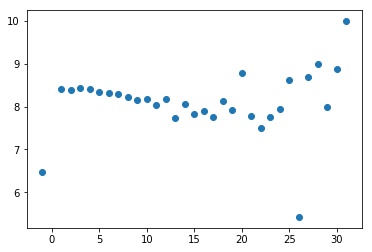

In [18]:
d = {}
for i in stays:
    if i not in d:
        d[i] = 1
    else:
        d[i] = d[i] + 1
pairs = []
for i in range(len(stays)):
    pairs.append((int(stays[i]), reviewer_score[i]))

#dictionary of stays and reviewer_score
d = defaultdict(list)
for i in pairs:
    d[i[0]].append(i[1])
    
#dictionary of stays and average reviewer_score
average = {}
for i in d:
    l = d[i]
    s = 0
    for val in l:
        s = s + val
    average[i] = s/len(l)

list_of_average = []
list_of_stays = []
for i in average:
    list_of_average.append(average[i])
    list_of_stays.append(i)
    
plt.scatter(list_of_stays, list_of_average)
plt.show()

The longer a stay, the lower the review score, but after 22 days roughly, it begins to increase

In [19]:
df['Duration of Stay'] = pd.Series(stays).values

### RACIST relationship

In [129]:
nationalities = set()
for i in df['Reviewer_Nationality']:
    nationalities.add(i)
    
#map that encodes a nationaliy to a real number
nationality_encoding = defaultdict(int)
nationalities = list(nationalities)

#Create encodings
for i in range(len(nationalities)):
    nationality = nationalities[i]
    nationality_encoding[nationality] = i
    
encodings = []
for i in df['Reviewer_Nationality']:
    encodings.append(nationality_encoding[i])
    
df['Reviewer_nationality'] = pd.Series(encodings).values

Nationality of reviewer plays little effect on the result. Theta for nationality is -9.12568450e-04

In [133]:
list(df)

['Hotel_Address',
 'Additional_Number_of_Scoring',
 'Review_Date',
 'Average_Score',
 'Hotel_Name',
 'Reviewer_Nationality',
 'Negative_Review',
 'Review_Total_Negative_Word_Counts',
 'Total_Number_of_Reviews',
 'Positive_Review',
 'Review_Total_Positive_Word_Counts',
 'Total_Number_of_Reviews_Reviewer_Has_Given',
 'Reviewer_Score',
 'Tags',
 'days_since_review',
 'lat',
 'lng',
 'Country',
 'Month',
 'Trip Type',
 'Duration of Stay',
 'Reviewer_nationality']

## Part 2: Predictive Task: Exact Score Prediction

Predictive Task: Attempt to predict the score the reviewer gave the hotel

In [170]:
training, test = train_test_split(df, test_size=0.3)

In [258]:
# Function that converts a list of real-values ratings into a list of Stars Rating

def getStars(l):
    star_ratings = []
    for ratings in l:
        if (ratings <= 2):
            star_ratings.append(1)
        elif(2 < ratings <= 4):
            star_ratings.append(2)
        elif(4 < ratings <= 6):
            star_ratings.append(3)
        elif(6 < ratings <= 8):
            star_ratings.append(4)
        elif(8 < ratings):
            star_ratings.append(5)
        
    return star_ratings

In [208]:
# Returns the accuracy (True Labels/ Total Labels) given a list of predictions and labels
def getAccuracy(predictions, labels):
    totalCorrect = 0;
    for i in range(len(labels)):
        if(predictions[i] == labels[i]):
            totalCorrect += 1
    return totalCorrect/len(labels)

### Baseline/Trivial predictor: Use hotel's average score to predict reviewer score - R^2 = 0.13, Acc = 63%

In [254]:
# Baseline that simply returns the average score of the hotel for the user's score

def trivialFeature(datum):
    feat = [datum['Average_Score']]
    return feat
X_train_trivial = [trivialFeature(row) for index, row in training.iterrows()]

# Evaluate accuracy of model
trainMSE = mean_squared_error(y_train, X_train_trivial)
print("Training MSE:", trainMSE)
r2 = r2_score(y_train, X_train_trivial)
print("Training R-Squared:", r2)

# Convert predictions to stars and predict star accuracy
X_trivial = []
for index, row in training.iterrows():
    X_trivial.append(row['Average_Score'])
X_train_trivial_stars = getStars(X_trivial)
y_train_stars = getStars(training['Reviewer_Score'].values)
print("Training Accuracy:", getAccuracy(X_train_trivial_stars, y_train_stars))

Training MSE: 2.33031336561
Training R-Squared: 0.131677917494
Training Accuracy: 0.6331409134221198


In [256]:
X_test_trivial = [trivialFeature(row) for index, row in test.iterrows()]
y_test = [row['Reviewer_Score'] for index,row in test.iterrows()]

testMSE = mean_squared_error(y_test, X_test_trivial)
print("Testing MSE:", testMSE)
r2 = r2_score(y_test, X_test_trivial)
print("Testing R-Squared:", r2)

# Convert predictions to stars and predict star accuracy
X_trivial = []
for index, row in test.iterrows():
    X_trivial.append(row['Average_Score'])
X_test_trivial_stars = getStars(X_trivial)
y_test_stars = getStars(test['Reviewer_Score'].values)
print("Testning Accuracy:", getAccuracy(X_test_trivial_stars, y_test_stars))

Testing MSE: 2.32537092333
Testing R-Squared: 0.132302225885
Testning Accuracy: 0.6328964206770854


### Model I: Build feature matrix from various dataframe columns - R^2 = .308, Acc = 68.07%

In [282]:
def feature(datum):
    feat = [1, datum['Country'], datum['Trip Type'],
            datum['Average_Score'], datum['Review_Total_Positive_Word_Counts'],
            datum['Review_Total_Negative_Word_Counts']]
    return feat

In [283]:
X_train = [feature(row) for index, row in training.iterrows()]
y_train = [row['Reviewer_Score'] for index,row in training.iterrows()]
theta, residuals, rank, s = numpy.linalg.lstsq(X_train, y_train)
theta

array([ 1.18450782, -0.02178307, -0.21926756,  0.87785693,  0.01743257,
       -0.02076792])

In [259]:
predictions_train = []

for index, row in training.iterrows():
    predictions_train.append(theta[0] + theta[1] * float(row['Country']) + 
                             theta[2] * float(row['Trip Type']) +  
                             theta[3] * float(row['Average_Score']) + theta[4] * float(row['Review_Total_Positive_Word_Counts']) +
                             theta[5] * float(row['Review_Total_Negative_Word_Counts']))

# Evaluate accuracy of model
trainMSE = mean_squared_error(y_train, predictions_train)
print("Training MSE:", trainMSE)
r2 = r2_score(y_train, predictions_train)
print("Training R-Squared:", r2)

# Convert predictions to stars and predict star accuracy
predictions_train_stars = getStars(predictions_train)
print("Training Accuracy:", getAccuracy(predictions_train_stars, y_train_stars))

Training MSE: 1.85523502622
Training R-Squared: 0.30870175433
Training Accuracy: 0.6807703813681388


In [260]:
X_test = [feature(row) for index, row in test.iterrows()]
y_test = [row['Reviewer_Score'] for index,row in test.iterrows()]
theta, residuals, rank, s = numpy.linalg.lstsq(X_test, y_test)

predictions_test = []

for index, row in test.iterrows():
    predictions_test.append(theta[0] + theta[1] * float(row['Country']) + 
                             theta[2] * float(row['Trip Type']) +  
                             theta[3] * float(row['Average_Score']) + theta[4] * float(row['Review_Total_Positive_Word_Counts']) +
                             theta[5] * float(row['Review_Total_Negative_Word_Counts']))

# Evaluate accuracy of model
testMSE = mean_squared_error(y_test, predictions_test)
print("Testing MSE:", testMSE)
r2 = r2_score(y_test, predictions_test)
print("Testing R-Squared:", r2)

# Convert predictions to stars and predict star accuracy
predictions_test_stars = getStars(predictions_test)
print("Testing Accuracy:", getAccuracy(predictions_test_stars, y_test_stars))

Testing MSE: 1.85349503615
Testing R-Squared: 0.308379793922
Testing Accuracy: 0.6813898475976267


### Model II: Build feature matrix from occurrence of words - R^2 = .315, Acc = 68.41%

In [236]:
def featurePos(datum):
    feat = [0]*(len(uniquePosWords))
    r = ''.join([c for c in datum['Positive_Review'].lower() if not c in punctuation])
    for w in r.split():
        if w in uniquePosWords:
            feat[wordIdPos[w]] = 1
    feat.append(1) #offset
    return feat

def featureNeg(datum):
    feat = [0]*(len(uniqueNegWords))
    r = ''.join([c for c in datum['Negative_Review'].lower() if not c in punctuation])
    for w in r.split():
        if w in uniqueNegWords:
            feat[wordIdNeg[w]] = 1
    return feat

In [176]:
# Extract most popular words in positive reviews

### Ignore capitalization and remove punctuation
posWordCount = defaultdict(int)
punctuation = set(string.punctuation)

for index, row in training.iterrows():
    r = ''.join([c for c in row['Positive_Review'] if not c in punctuation])
    for w in r.split():
        posWordCount[w] += 1
        
### Just take the most popular words...

posCounts = [(posWordCount[w], w) for w in posWordCount]
posCounts.sort()
posCounts.reverse()

posWords = [x[1] for x in posCounts[:500]]

# Extract most popular words in negative reviews

### Ignore capitalization and remove punctuation
negWordCount = defaultdict(int)

for index, row in training.iterrows():
    r = ''.join([c for c in row['Negative_Review'] if not c in punctuation])
    for w in r.split():
        negWordCount[w] += 1
        
### Just take the most popular words...

negCounts = [(negWordCount[w], w) for w in negWordCount]
negCounts.sort()
negCounts.reverse()

negWords = [x[1] for x in negCounts[:500]]

In [177]:
# Remove words that appear in both positive and negative sets to handle ambiguity in review
posWords = set(posWords)
negWords = set(negWords)
uniquePosWords = set()
uniqueNegWords = set()

uniquePosWords = posWords - negWords
uniqueNegWords = negWords - posWords

In [178]:
wordIdPos = dict(zip(uniquePosWords, range(len(posWords))))
wordIdNeg = dict(zip(uniqueNegWords, range(len(negWords))))

In [237]:
X_train_words_pos = np.array([featurePos(row) for index, row in training.iterrows()])
X_train_words_neg = np.array([featureNeg(row) for index, row in training.iterrows()])

In [238]:
X_train_words = np.concatenate((X_train_words_pos, X_train_words_neg), axis=1)

In [239]:
theta, residuals, rank, s = numpy.linalg.lstsq(X_train_words, y_train)

In [240]:
X_predictions_words = []

for i in X_train_words:
    pred = 0
    for val in range(len(i)):
        pred += i[val] * theta[val]
    X_predictions_words.append(pred)

In [261]:
# Evaluate accuracy of model
trainMSE = mean_squared_error(y_train, X_predictions_words)
print("Training MSE:", trainMSE)
r2 = r2_score(y_train, X_predictions_words)
print("Training R-Squared:", r2)

# Convert predictions to stars and predict star accuracy
predictions_train_stars = getStars(X_predictions_words)
print("Training Accuracy:", getAccuracy(predictions_train_stars, y_train_stars))

Training MSE: 1.8376103848
Training R-Squared: 0.315269053634
Training Accuracy: 0.6841192634121479


In [266]:
X_test_words_pos = np.array([featurePos(row) for index, row in test.iterrows()])
X_test_words_neg = np.array([featureNeg(row) for index, row in test.iterrows()])
X_test_words = np.concatenate((X_test_words_pos, X_test_words_neg), axis=1)
theta, residuals, rank, s = numpy.linalg.lstsq(X_test_words, y_test)

X_predictions_words_test = []

for i in X_test_words:
    pred = 0
    for val in range(len(i)):
        pred += i[val] * theta[val]
    X_predictions_words_test.append(pred)
    
# Evaluate accuracy of model
testMSE = mean_squared_error(y_test, X_predictions_words_test)
print("Testing MSE:", testMSE)
r2 = r2_score(y_test, X_predictions_words_test)
print("Testing R-Squared:", r2)

# Convert predictions to stars and predict star accuracy
predictions_test_stars = getStars(X_predictions_words_test)
print("Testing Accuracy:", getAccuracy(predictions_test_stars, y_test_stars))

Testing MSE: 1.83234743183
Testing R-Squared: 0.316270891646
Testing Accuracy: 0.6865604115768927


### Model III: Combine Models I and II - R^2 = 0.402, Acc = 69.79%

In [272]:
X_train = np.array(X_train) # Basic feature matrix (Country, length of stay, etc.)
X_train_combined = np.concatenate((X_train, X_train_words), axis=1)

In [273]:
theta, residuals, rank, s = numpy.linalg.lstsq(X_train_combined, y_train)

In [274]:
X_predictions_combined = []

for i in X_train_combined:
    pred = 0
    for val in range(len(i)):
        pred += float(i[val]) * theta[val]
    if pred > 10: #Because sometimes the prediction exceeds 10
        X_predictions_combined.append(10)
    elif pred < 0: #Because sometimes the prediction is negative
        X_predictions_combined.append(1)
    else:
        X_predictions_combined.append(pred)

In [276]:
# Evaluate accuracy of model
trainMSE = mean_squared_error(y_train, X_predictions_combined)
print("Training MSE:", trainMSE)
r2 = r2_score(y_train, X_predictions_combined)
print("Training R-Squared:", r2)

# Convert predictions to stars and predict star accuracy
predictions_train_stars = getStars(X_predictions_combined)
print("Training Accuracy:", getAccuracy(predictions_train_stars, y_train_stars))

Training MSE: 1.60299498207
Training R-Squared: 0.402691517107
Training Accuracy: 0.6979579852416513


In [279]:
X_test = np.array(X_test)
X_test_combined = np.concatenate((X_test, X_test_words), axis=1)

X_predictions_combined = []

for i in X_test_combined:
    pred = 0
    for val in range(len(i)):
        pred += float(i[val]) * theta[val]
    if pred > 10: #Because sometimes the prediction exceeds 10
        X_predictions_combined.append(10)
    elif pred < 0: #Because sometimes the prediction is negative
        X_predictions_combined.append(1)
    else:
        X_predictions_combined.append(pred)

In [281]:
# Evaluate accuracy of model
testMSE = mean_squared_error(y_test, X_predictions_combined)
print("Testing MSE:", testMSE)
r2 = r2_score(y_test, X_predictions_combined)
print("Testing R-Squared:", r2)

# Convert predictions to stars and predict star accuracy
predictions_test_stars = getStars(X_predictions_combined)
print("Testing Accuracy:", getAccuracy(predictions_test_stars, y_test_stars))

Testing MSE: 1.60289896403
Testing R-Squared: 0.40188816792
Testing Accuracy: 0.6997582761339693


## Interesting note, calculating MSE and R-Squared of stars is very different from actual ratings

In [210]:
y_train_stars = getStars(training['Reviewer_Score'].values)
X_predictions_stars = getStars(X_predictions_combined)

In [206]:
# Evaluate accuracy of model
trainMSE = mean_squared_error(y_train_stars, X_predictions_stars)
print("MSE:", trainMSE)
r2 = r2_score(y_train_stars, X_predictions_stars)
print("R-Squared:", r2)

MSE: 0.428108449487
R-Squared: 0.204912976711


MSE went down significantly but R-Squared went down by half. Will measure accuracy differently